# Import Packages

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Function To Plot Images

In [10]:
def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    ax1.set_title(orig_title, fontsize=30)
    ax1.imshow(orig_image)
    ax2.set_title(processed_title, fontsize=30)
    ax2.imshow(processed_image, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Applying Sobel Filter

In [11]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    sobel_mask = binary_output
    # Return the result
    return sobel_mask

In [12]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    dir_mask = binary_output
    # Return the binary image
    return dir_mask

In [13]:
def combine_thresh(img, s_thresh=(100, 255), l_thresh=(120, 255)):
    
    # Undistort
    undist = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    # Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    #combined = ((grad_x == 1)  & (grad_y == 1) & (mag_binary == 1) & (dir_binary == 1))
    grad_x = abs_sobel_thresh(gray, 'x', thresh=(10, 200))
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    combined = ((grad_x == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # Apply color threshold for better detection of yello and white lines in all environmental condition
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Select S channel because it is usually the best performant
    # for this task. R channel also performs similarly.
    s_channel = hls[:,:,2] 
    l_channel = hls[:,:,1]
    
     # S channel performs well for detecting bright yellow and white lanes
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.   
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1
    
    #binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)

    return thresholded

# lane detecting  

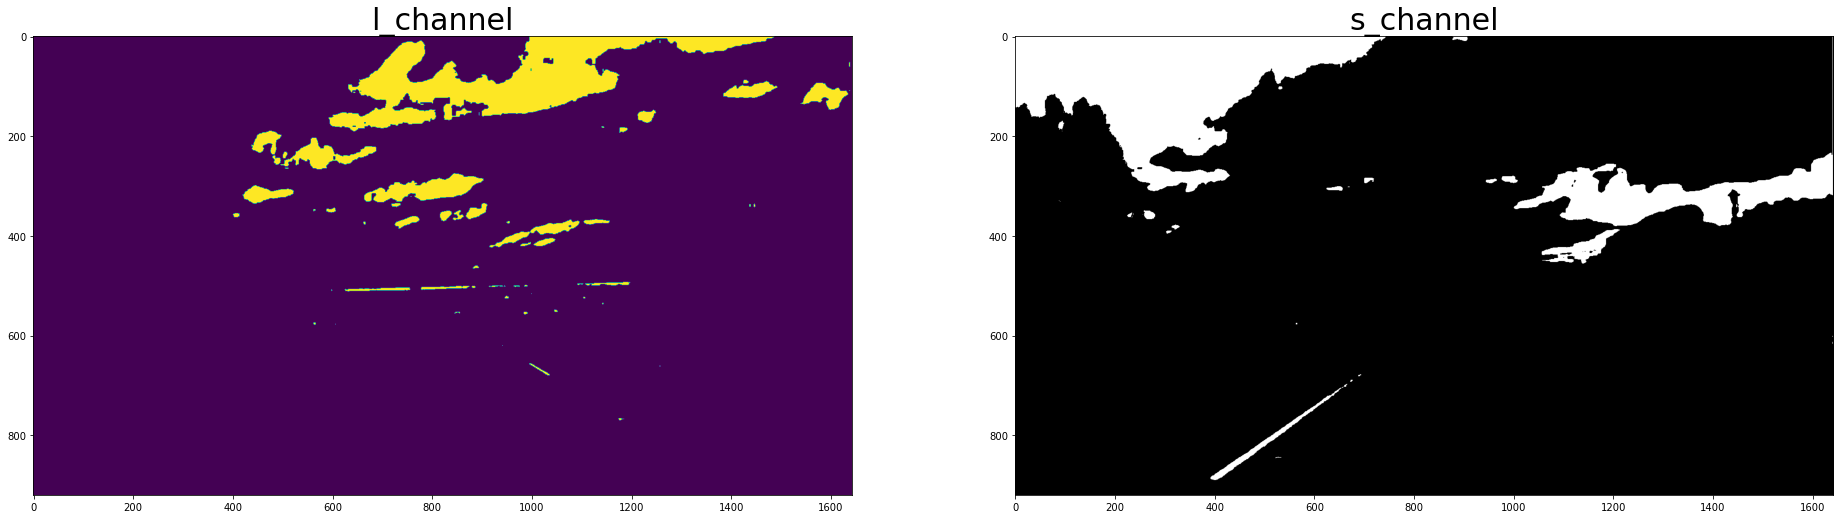

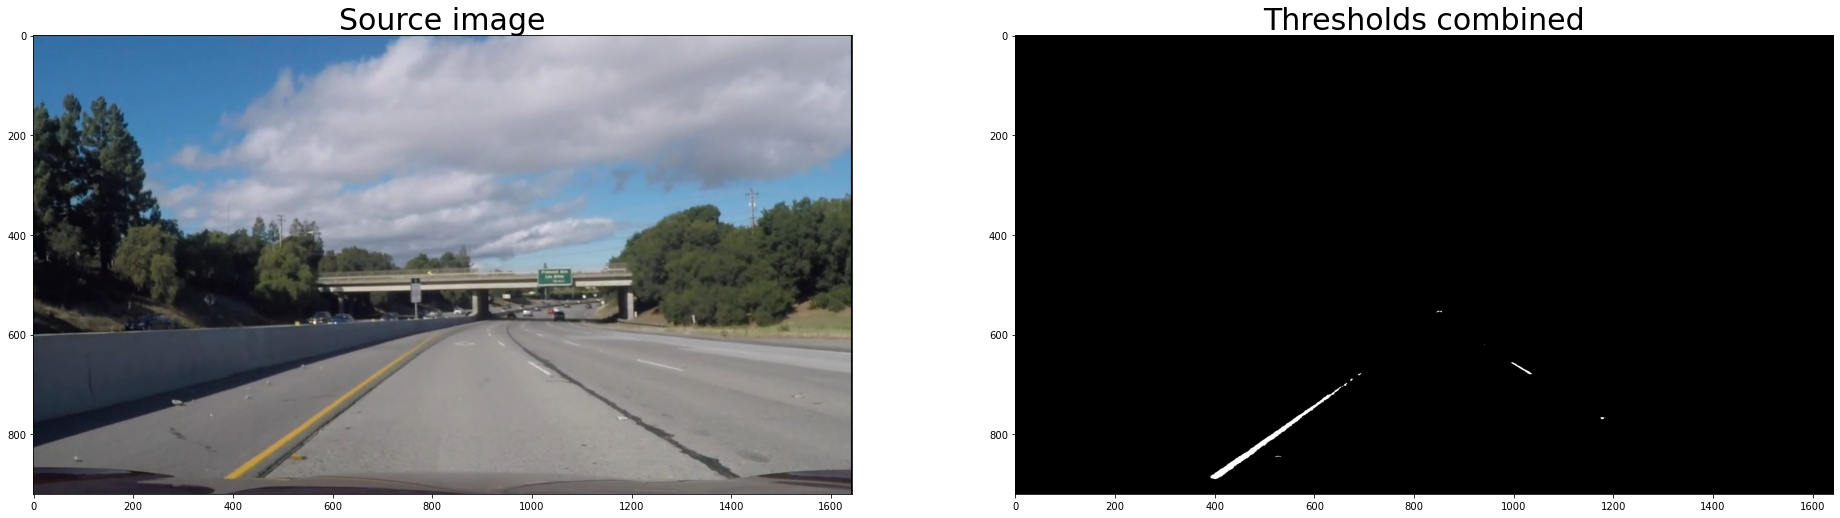

In [20]:
def combine_thresh2(img, s_thresh=80, l_thresh=190):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1] 
    s = hls[:,:,2]

    height, width = l.shape 
    l =cv2.GaussianBlur(l, (5, 5), 0)
    l_channel = np.zeros_like(l)
    l_channel [ (l > l_thresh) ] =255

    s =cv2.GaussianBlur(s, (5, 5), 0)
    y_channel = np.zeros_like(l)
    y_channel [ (s> s_thresh) &(l>100)] =255


    
    combine= np.zeros_like(l_channel)
    combine [ (y_channel==255)| (l_channel==255)]=255


    plt_images(l_channel, 'l_channel', y_channel, 's_channel')

    
    mask = np.zeros_like(combine)
    region_of_interest_vertices = np.array([ [0,height-1], [width/2, int(5.7/10*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(combine, mask)
    
    return thresholded

# Load a test image, convert to RGB and undistort it
img = plt.imread('test1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Run the function
combined = combine_thresh2(img,s_thresh=85, l_thresh=190)

# Plot the result
plt_images(img, 'Source image', combined, 'Thresholds combined')


# Perspective wrap

In [ ]:
def binary(img):
    
    thresholded = thresholding(img)
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    M = cv2.getPerspectiveTransform(source, dst)
    M_inv = cv2.getPerspectiveTransform(dst, source)
    img_size = (image_shape[1], image_shape[0])

    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    return warped, M_inv

# Using sliding window technique to detect the lane

In [ ]:
def fitlines(warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    return left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty
     

# Calculating the vehicle position and radius of curvature

In [1]:
def lane_curvatures(lefty, leftx, righty, rightx, ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/730 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # estimating the vehicle position away from the center of the lane.
    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    
    return center,left_curverad, right_curverad

In [ ]:
def draw_lane(img, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, M_inv):

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    
    # Creating Text and set font parameters
    TextL = "Left  Curvature: " + str(int(left_curverad)) + " m"
    TextR = "Right Curvature: " + str(int(right_curverad))+ " m"
    if (center > 0):
        TextC = "Vehicle is " + str(round(float(center),3))+ "m right of center"
    elif (center < 0):
        TextC = "Vehicle is " + str(round(float(center),3))+ "m left of center"    
    else:
        TextC = "Vehicle is exactly on center"
        
    fontScale=1.5
    thickness=3
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    # Using CV2 putText to write text into images
    cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, TextR, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, TextC, (100,170), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

In [1]:
def software_pipeline(img):
    
    # Binary Undistorced Warped Image
    binary_warped, M_inv = binary(img)
    
    # Fit the lines
    left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = fitlines(binary_warped)    
    
    # Calulating the left and right lines curvatures
    left_curverad, right_curverad = lane_curvatures(lefty, leftx, righty, rightx, ploty)
    
    # Draw Lane between road lines
    processed_lane = draw_lane(img, binary_warped, left_fit, right_fit, ploty, left_curverad, right_curverad, M_inv)

    return processed_lane

# Saving the output video

In [ ]:
#Create video file pipeline
output = 'writeup_images/out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(software_pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))